In [1]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [24]:
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

smoke_test = 'CI' in os.environ

def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader, test_set

In [14]:
class Decoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        """
        Decoder parametrizes the likelihood p(x|z)
        """

        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)

        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):


        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [46]:
class Encoder(nn.Module):
    def __init__(self,input_dim, z_dim, hidden_dim):
        super().__init__()
        """
        Encoder parametrizes the variational distribution
        q(z|x)
        """
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):

        x = x.reshape(-1, self.input_dim)

        hidden = self.softplus(self.fc1(x))

        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [47]:
class VAE(nn.Module):
    def __init__(self,input_dim, z_dim=50, hidden_dim=400, use_cuda=True):
        # Define input dimension for data
        self.input_dim = input_dim
        super().__init__()
        # Define instances of encoder and decoder
        self.encoder = Encoder(input_dim, z_dim, hidden_dim)
        self.decoder = Decoder(input_dim, z_dim, hidden_dim)

        if use_cuda:

            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim


    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # Define the prior over z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            loc_img = self.decoder(z)
            
            # Define likelihood p(x|z)

            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, self.input_dim))


    def guide(self, x):

        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # Get the parameters of variational distribution q(z|x)
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        with torch.no_grad():
            z_loc, z_scale = self.encoder(x)
            z = dist.Normal(z_loc, z_scale).sample()

            loc_img = self.decoder(z)
        return loc_img

In [49]:
# Training Function
def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.

    for x, _ in train_loader:
        if use_cuda:
            x = x.cuda()

        epoch_loss += svi.step(x)

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [50]:
# Test Function
def evaluate(svi, test_loader, use_cuda=False):

    test_loss = 0.

    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [84]:

LEARNING_RATE = 1.0e-3
USE_CUDA = True


NUM_EPOCHS = 21
TEST_FREQUENCY = 1
train_loader, test_loader, test_set = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)


pyro.clear_param_store()

# Setup the VAE,  optimizer and svi scheme
vae = VAE(input_dim = 784)
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# Store the losses for plotting
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    vae.train()
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    vae.eval()
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:

        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
                
            

[epoch 000]  average training loss: 213.6149
[epoch 000] average test loss: 183.7304
[epoch 001]  average training loss: 167.0262
[epoch 001] average test loss: 155.1916
[epoch 002]  average training loss: 149.3941
[epoch 002] average test loss: 143.1546
[epoch 003]  average training loss: 139.4460
[epoch 003] average test loss: 134.6662
[epoch 004]  average training loss: 132.4204
[epoch 004] average test loss: 128.6589
[epoch 005]  average training loss: 126.9342
[epoch 005] average test loss: 123.6907
[epoch 006]  average training loss: 122.6053
[epoch 006] average test loss: 120.0798
[epoch 007]  average training loss: 119.4612
[epoch 007] average test loss: 117.3618
[epoch 008]  average training loss: 117.0240
[epoch 008] average test loss: 115.4377
[epoch 009]  average training loss: 115.1430
[epoch 009] average test loss: 113.9116
[epoch 010]  average training loss: 113.7871
[epoch 010] average test loss: 112.2679
[epoch 011]  average training loss: 112.6671
[epoch 011] average 

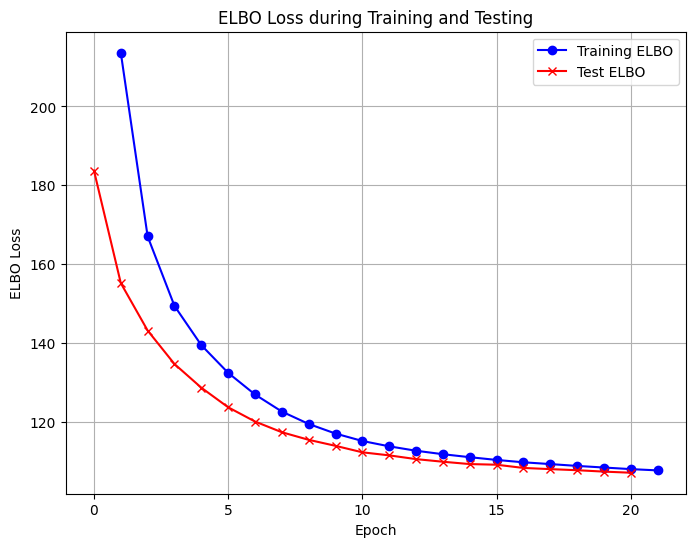

In [85]:
import matplotlib.pyplot as plt

def plot_elbo(train_elbo, test_elbo, test_frequency):
    epochs = list(range(1, len(train_elbo) + 1))
    test_epochs = list(range(0, len(test_elbo) * test_frequency, test_frequency))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_elbo, label="Training ELBO", color="blue", marker='o')
    plt.plot(test_epochs, test_elbo, label="Test ELBO", color="red", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("ELBO Loss")
    plt.title("ELBO Loss during Training and Testing")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_elbo(train_elbo, test_elbo, TEST_FREQUENCY)


In [86]:
def plot_reconstructed_images(vae, test_loader, num_images=10, use_cuda=False):
    vae.eval()
    original_images, _ = next(iter(test_loader))
    if use_cuda:
        original_images = original_images.cuda()

    with torch.no_grad():
        reconstructed_images = vae.reconstruct_img(original_images[:num_images])

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

    for i in range(num_images):

        axes[0, i].imshow(original_images[i].cpu().squeeze().numpy(), cmap='gray')
        axes[0, 0].set_title("Original")
        axes[0, i].axis('off')

        img = reconstructed_images[i].cpu().numpy().reshape(28, 28)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, 0].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()


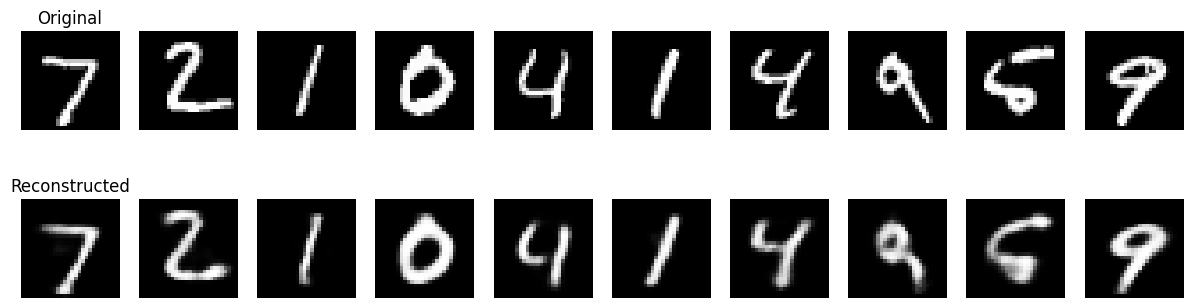

In [87]:
plot_reconstructed_images(vae, test_loader, num_images=10, use_cuda=USE_CUDA)
